[info] Downloading dataset...
[info] Extracted: SMSSpamCollection


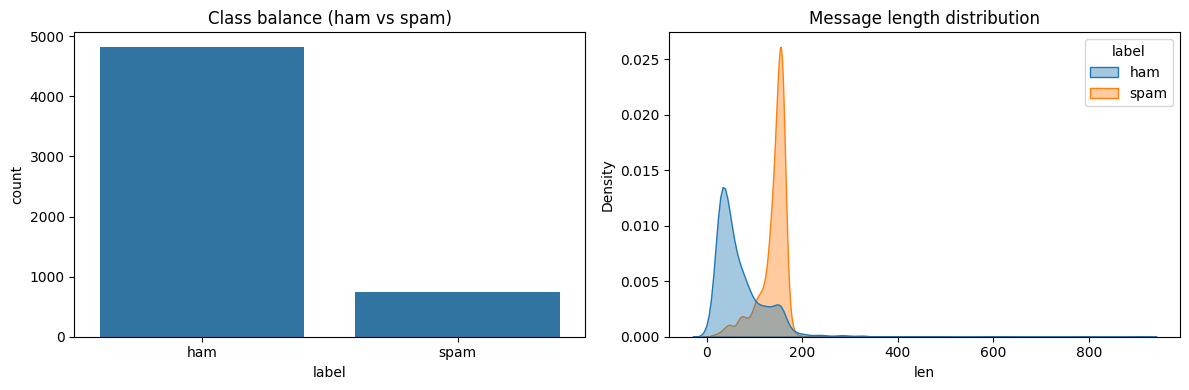

CV F1 (mean±std): 0.9583 ± 0.0049
Test metrics [svm]: acc=0.9919 prec=0.9795 rec=0.9597 f1=0.9695


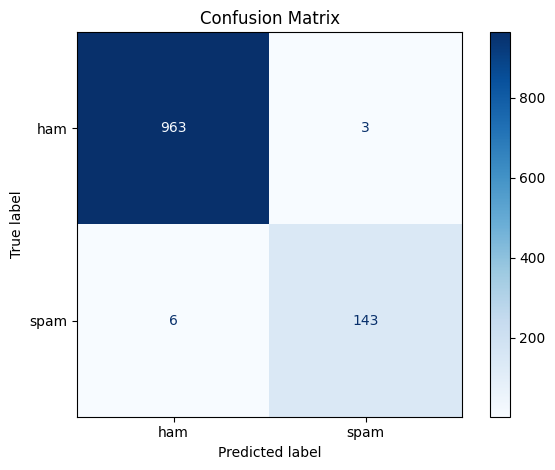

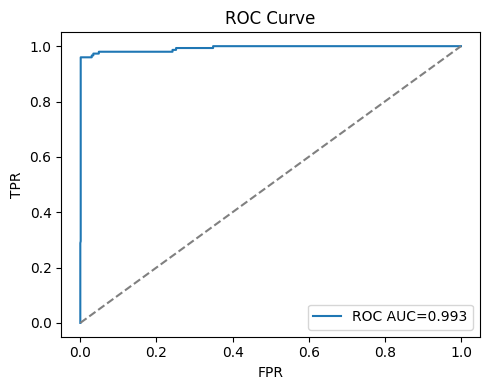

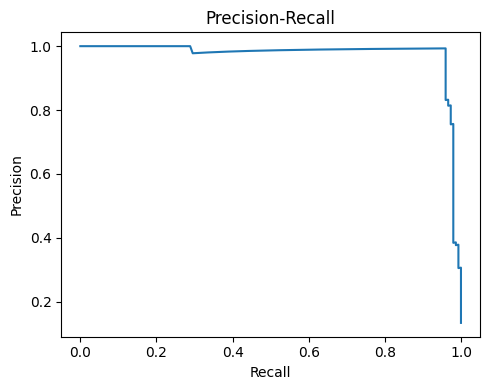

[info] model has no coef_; skipping top features
[info] Saved model to sms_spam_model.joblib


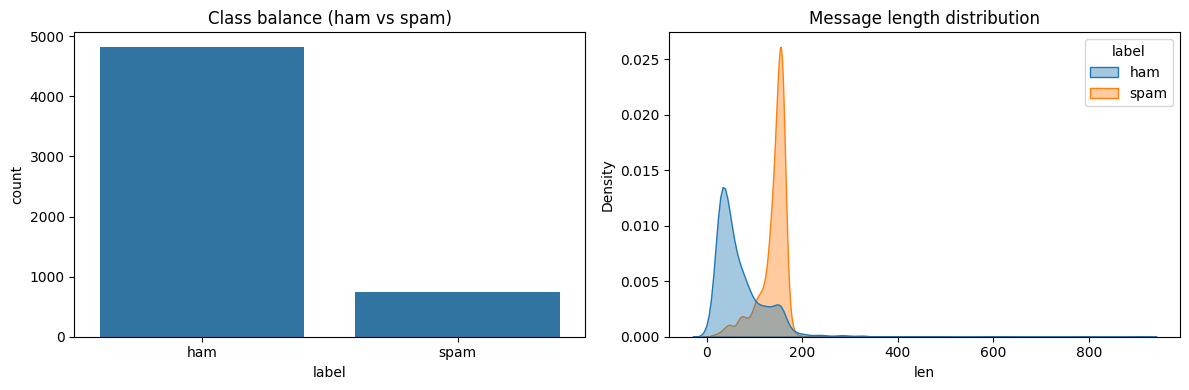

CV F1 (mean±std): 0.9583 ± 0.0049
Test metrics [svm]: acc=0.9919 prec=0.9795 rec=0.9597 f1=0.9695


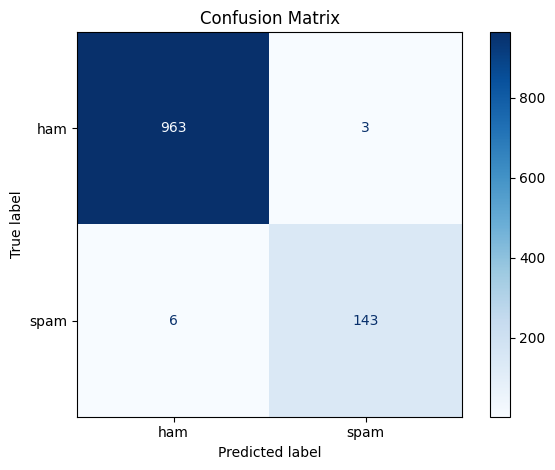

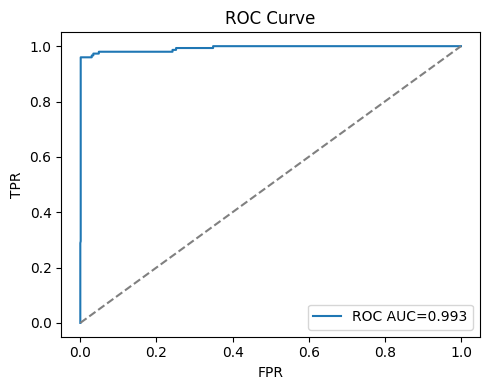

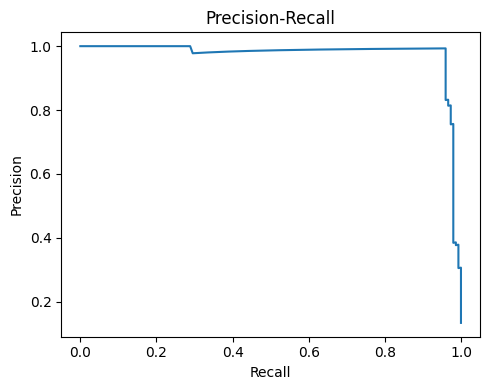

[info] model has no coef_; skipping top features
[info] Saved model to sms_spam_model.joblib


In [2]:
# sms_spam_ml.py
# End-to-end ML: SMS Spam detection (TF-IDF + Linear SVM)
# Works in Jupyter and terminal

import os, sys, argparse, re, io, zipfile, urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,
    precision_recall_curve, classification_report
)
import joblib

DATA_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"  # UCI SMS Spam [web:141]
DATA_ZIP = "smsspamcollection.zip"
DATA_TXT = "SMSSpamCollection"
MODEL_PATH = "sms_spam_model.joblib"

def in_notebook():
    try:
        from IPython import get_ipython
        return get_ipython() is not None
    except Exception:
        return False

def download_dataset():
    if os.path.exists(DATA_TXT):
        return DATA_TXT
    if not os.path.exists(DATA_ZIP):
        print("[info] Downloading dataset...")
        urllib.request.urlretrieve(DATA_URL, DATA_ZIP)
    with zipfile.ZipFile(DATA_ZIP, "r") as zf:
        zf.extractall(".")
    print("[info] Extracted:", DATA_TXT)
    return DATA_TXT

def load_sms_dataframe():
    path = download_dataset()
    # File format: label \t message
    df = pd.read_csv(path, sep="\t", header=None, names=["label", "text"], encoding="utf-8")
    df["target"] = (df["label"] == "spam").astype(int)
    return df

def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r"http[s]?://\S+", " URL ", s)
    s = re.sub(r"\b\d+\b", " NUM ", s)
    s = re.sub(r"[^a-zA-Z#@_\'\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def eda_plots(df):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.countplot(data=df, x="label", ax=axes[0])
    axes[0].set_title("Class balance (ham vs spam)")
    df["len"] = df["text"].str.len()
    sns.kdeplot(data=df, x="len", hue="label", ax=axes[1], fill=True, alpha=0.4, common_norm=False)
    axes[1].set_title("Message length distribution")
    plt.tight_layout()
    plt.show()

def build_pipeline(model="svm", ngram_max=2, min_df=2):
    vectorizer = TfidfVectorizer(
        preprocessor=clean_text,
        ngram_range=(1, ngram_max),
        min_df=min_df,
        max_df=0.9,
        strip_accents="unicode",
        sublinear_tf=True
    )
    if model == "svm":
        base = LinearSVC()  # strong baseline for text
        clf = CalibratedClassifierCV(base, cv=5)  # for ROC/PR probabilities
    else:
        clf = LogisticRegression(max_iter=2000, n_jobs=None)
    pipe = Pipeline([
        ("tfidf", vectorizer),
        ("clf", clf)
    ])
    return pipe

def evaluate(model, X_test, y_test, title_suffix=""):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Test metrics{title_suffix}: acc={acc:.4f} prec={prec:.4f} rec={rec:.4f} f1={f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(cm, display_labels=["ham","spam"])
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # ROC & PR curves (need decision_function or predict_proba)
    try:
        if hasattr(model, "predict_proba"):
            scores = model.predict_proba(X_test)[:,1]
        else:
            scores = model.decision_function(X_test)
        fpr, tpr, _ = roc_curve(y_test, scores)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"ROC AUC={roc_auc:.3f}")
        plt.plot([0,1], [0,1], linestyle="--", color="grey")
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend()
        plt.tight_layout(); plt.show()

        precs, recs, _ = precision_recall_curve(y_test, scores)
        plt.figure(figsize=(5,4))
        plt.plot(recs, precs, label="PR Curve")
        plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall")
        plt.tight_layout(); plt.show()
    except Exception as e:
        print("[warn] Could not plot ROC/PR:", e)

def top_features(model, n=20):
    # Works for linear models with coef_
    try:
        vec = model.named_steps["tfidf"]
        clf = model.named_steps["clf"]
        if hasattr(clf, "base_estimator_"):  # Calibrated LinearSVC
            coef = clf.base_estimator_.coef_.ravel()
        elif hasattr(clf, "coef_"):
            coef = clf.coef_.ravel()
        else:
            print("[info] model has no coef_; skipping top features")
            return
        vocab = np.array(vec.get_feature_names_out())
        top_spam_idx = np.argsort(coef)[-n:]
        top_ham_idx = np.argsort(coef)[:n]
        print("\nTop spam n-grams:")
        print(vocab[top_spam_idx][::-1])
        print("\nTop ham n-grams:")
        print(vocab[top_ham_idx])
    except Exception as e:
        print("[warn] top_features failed:", e)

def train_eval(model_kind="svm", ngram_max=2, min_df=2, test_size=0.2, seed=42):
    df = load_sms_dataframe()
    X = df["text"].values
    y = df["target"].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=seed
    )
    pipe = build_pipeline(model=model_kind, ngram_max=ngram_max, min_df=min_df)
    # CV for a quick sanity check
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="f1")
    print(f"CV F1 (mean±std): {scores.mean():.4f} ± {scores.std():.4f}")

    pipe.fit(X_train, y_train)
    evaluate(pipe, X_test, y_test, title_suffix=f" [{model_kind}]")
    top_features(pipe, n=15)
    joblib.dump(pipe, MODEL_PATH)
    print(f"[info] Saved model to {MODEL_PATH}")
    return pipe

def predict_texts(model_path, texts):
    model = joblib.load(model_path)
    preds = model.predict(texts)
    for t, p in zip(texts, preds):
        label = "SPAM" if int(p)==1 else "HAM"
        print(f"[{label}] {t[:80]}")

def parse_args():
    p = argparse.ArgumentParser(description="SMS Spam detection (TF-IDF + Linear SVM)")
    p.add_argument("--train", action="store_true", help="Train/evaluate and save model")
    p.add_argument("--eda", action="store_true", help="Show class balance and length plots")
    p.add_argument("--predict", type=str, default=None, help="Path to text file (one message per line)")
    p.add_argument("--model", type=str, default=MODEL_PATH, help="Path to saved model")
    p.add_argument("--svm", action="store_true", help="Use LinearSVC (default)")
    p.add_argument("--logreg", action="store_true", help="Use LogisticRegression")
    p.add_argument("--ngram", type=int, default=2, help="Max n-gram length")
    p.add_argument("--min_df", type=int, default=2, help="Min doc freq")
    if in_notebook():
        # No CLI flags in notebooks; default to train + EDA
        args = p.parse_args(args=[])
        args.train = True
        args.eda = True
        return args
    return p.parse_args()

def main():
    args = parse_args()
    if args.eda or args.train or args.predict:
        df = load_sms_dataframe()
        if args.eda:
            eda_plots(df)
    if args.train:
        model_kind = "svm" if (args.svm or not args.logreg) else "logreg"
        train_eval(model_kind=model_kind, ngram_max=args.ngram, min_df=args.min_df)
    if args.predict:
        with open(args.predict, "r", encoding="utf-8") as f:
            lines = [ln.strip() for ln in f if ln.strip()]
        predict_texts(args.model, lines)

if __name__ == "__main__":
    main()


In [3]:
import joblib

# Load the saved pipeline
model = joblib.load("sms_spam_model.joblib")  # adjust path if saved elsewhere

# Classify some messages
msgs = [
    "Get FREE recharge now! Click this link",
    "Kal 6 baje milna cafeteria me?",
    "Your OTP is 432199. Do not share."
]
preds = model.predict(msgs)
labels = ["HAM" if p==0 else "SPAM" for p in preds]
list(zip(labels, msgs))



[('HAM', 'Get FREE recharge now! Click this link'),
 ('HAM', 'Kal 6 baje milna cafeteria me?'),
 ('HAM', 'Your OTP is 432199. Do not share.')]

In [6]:
import os
print(os.getcwd())
model = joblib.load(r"C:\Users\Deepak joshi\Desktop\minorpppai\smsspamcollectpor\sms_spam_model.joblib")


c:\Users\Deepak joshi\Desktop\minorpppai\smsspamcollectpor


In [10]:
import os, glob, joblib

# 1) Show where we are
print("CWD:", os.getcwd())

# 2) Try multiple likely locations for the model
candidate_paths = [
    "sms_spam_model.joblib",
    "./smsspamcollector/sms_spam_model.joblib",
    "../sms_spam_model.joblib",
]

# Also search the entire workspace once (depth-limited)
workspace_root = os.getcwd()
for pat in [
    os.path.join(workspace_root, "**", "sms_spam_model.joblib"),
]:
    for p in glob.glob(pat, recursive=True):
        candidate_paths.append(p)

model_path = next((p for p in candidate_paths if os.path.exists(p)), None)
if not model_path:
    raise FileNotFoundError("Could not find sms_spam_model.joblib. Move it next to the notebook or set model_path to its full path.")

print("Using model:", model_path)
model = joblib.load(model_path)

# 3) Load messages file if it exists; else use sample messages
txt_path = "messages.txt"
if not os.path.isabs(txt_path):
    txt_path = os.path.join(os.getcwd(), txt_path)

if os.path.exists(txt_path):
    with open(txt_path, "r", encoding="utf-8") as f:
        lines = [ln.strip() for ln in f if ln.strip()]
    print(f"Loaded {len(lines)} messages from:", txt_path)
else:
    print("[info] messages.txt not found — using sample texts.")
    lines = [
        "Congratulations! You won a FREE voucher. Claim now.",
        "Kal 6 baje milna cafeteria me?",
        "Your OTP is 432199. Do not share.",
    ]

# 4) Predict
preds = model.predict(lines)
for msg, p in zip(lines, preds):
    print(("SPAM" if int(p) else "HAM"), "-", msg)


CWD: c:\Users\Deepak joshi\Desktop\minorpppai\smsspamcollectpor
Using model: sms_spam_model.joblib
[info] messages.txt not found — using sample texts.
SPAM - Congratulations! You won a FREE voucher. Claim now.
HAM - Kal 6 baje milna cafeteria me?
HAM - Your OTP is 432199. Do not share.
